In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import textwrap
from IPython.display import clear_output
import numpy as np
from ipywidgets import Button, HTML, Output
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

In [2]:
INPUT_PATH = "data/df_30topics10passes_intermed.csv"
RATER = "Quirin"

In [23]:
def lda_sample_and_rate(df_topics, topic_id,  prob_range = (0.25, 0.45), n = 100, seed = 42):
    """
    For determining thresholds
    Randomly sample items whose probability is within [lower_prob, upper_prob],
    collect manual ratings (1 = belongs, 0 = not).
    Returns a DataFrame with columns ['probability', 'rating'] of length n (or fewer if not enough speeches).
    """
    lower_prob, upper_prob = prob_range
    prob_col = f"topic_{topic_id}"
    candidates = df_topics[(df_topics[prob_col] >= lower_prob) & (df_topics[prob_col] <= upper_prob)]
    
    sampled = candidates.sample(n=min(n, len(candidates)), random_state=seed).reset_index(drop=True)
    sampled['rating'] = np.nan  # Initialize rating column
    ratings = []
    terminated_early = [False]

    current_index = [0]
    
    print(f"\n{'='*90}")
    print(f"Starting manual rating: {len(sampled)} speeches to rate.")
    print(f"{'='*90}\n")
    
    output = Output()
    display(output)
    
    def show_speech(index):
        with output:
            output.clear_output(wait=True)
            if index >= len(sampled) or terminated_early[0]:
                print(f"Rating complete! Rated {len(ratings)}/{len(sampled)} speeches.")
                # Add ratings to dataframe
                for i, rating in enumerate(ratings):
                    sampled.loc[i, 'rating'] = rating
                # Hide buttons after completion
                btn_correct.layout.display = 'none'
                btn_incorrect.layout.display = 'none'
                btn_skip.layout.display = 'none'
                return
            
            row = sampled.iloc[index]
            print(f"Progress: {index}/{len(sampled)} speeches rated")
            print(f"\nSpeech {index}/{len(sampled)} | Year: {row['year']} | Party block: {row['block']}")
            print(f"Topic probability: {row[prob_col]:.4f}")
            print(textwrap.fill(row["translatedText"], width=90))
    
    def on_button_click(_button, rating_value):
        ratings.append(rating_value)
        current_index[0] += 1
        show_speech(current_index[0])
    
    def on_skip_click(_button):
        terminated_early[0] = True
        show_speech(current_index[0])
    
    btn_correct = Button(description="1: Correct topic")
    btn_incorrect = Button(description="0: Incorrect topic")
    btn_skip = Button(description="Skip remaining", button_style='warning')
    
    btn_correct.on_click(lambda b: on_button_click(b, 1))
    btn_incorrect.on_click(lambda b: on_button_click(b, 0))
    btn_skip.on_click(on_skip_click)
    
    show_speech(0)
    display(btn_correct, btn_incorrect, btn_skip)
    
    # Return the full sampled dataframe with ratings (NaN for unrated)
    return sampled

In [4]:
# set working directory to project root
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("__file__")))))

In [7]:
# import topic probability data
df = pd.read_csv(INPUT_PATH, sep = "\t")

In [26]:
prob_range=(0.2, 0.4)
topic_id = 8

In [24]:
ratings = lda_sample_and_rate(df, topic_id=topic_id, prob_range=prob_range, n=100)


Starting manual rating: 100 speeches to rate.



Output()

Button(description='1: Correct topic', style=ButtonStyle())

Button(description='0: Incorrect topic', style=ButtonStyle())

Button(button_style='warning', description='Skip remaining', style=ButtonStyle())

In [25]:
ratings

,Unnamed: 0.1,Unnamed: 0,speaker,text,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,...,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,rating
0,142752,176942,Andor Deli,A migrációs válság nem összemosható a menekült...,2016-04-12,6.9. The situation in the Mediterranean and th...,65,,6398.0,8,...,0.000547,0.000547,0.000547,0.000547,0.147668,0.000547,0.000547,0.000547,0.000547,1.0
1,226001,278302,Josef Weidenholzer,Berichte über ertrunkene Flüchtlinge im Mittel...,2015-01-13,15. Recent human smuggling incidents in the Me...,65,,6399.0,8,...,0.000470,0.000470,0.000470,0.000470,0.000470,0.000470,0.084704,0.023376,0.000470,0.0
2,198028,241353,Christine Revault D'Allonnes Bonnefoy,La stratégie européenne relative à l'immigrati...,2015-06-24,18. Preparation of the European Council meetin...,25,,6399.0,8,...,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,0.000412,1.0
3,68231,88715,Birgit Sippel,Herr Präsident! Der Winterplan für Flüchtlinge...,2017-11-15,8. Winter plan for asylum seekers (debate)2017...,16,,6399.0,8,...,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,1.0
4,227877,280781,Rachida Dati,La gestion des flux migratoires en Europe cons...,2014-12-17,11.24. Situation in the Mediterranean and the ...,28,,6398.0,8,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.130554,0.000833,0.000833,0.000833,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,104672,132163,Jens Gieseke,Wir dürfen die südeuropäischen Mitgliedstaaten...,2016-09-15,12.4. Asylum: provisional measures in favour o...,70,bill_2168_ID,6398.0,8,...,0.001450,0.001450,0.001450,0.001450,0.001450,0.001450,0.001450,0.001450,0.001450,NaN
96,33743,44916,Malin Björk,Fru talman! Detta är inte en ny debatt. År 201...,2021-05-18,4. Recent deaths in the Mediterranean and sear...,10,,6402.0,9,...,0.025510,0.000337,0.000337,0.000337,0.000337,0.000337,0.000337,0.000337,0.000337,NaN
97,112126,140751,Андрей Ковачев,Подкрепих доклада с предложението за създаване...,2016-07-06,7.5. European Border and Coast Guard (A8-0200/...,134,bill_2236_ID bill_2236_ID,6398.0,8,...,0.000362,0.000362,0.000362,0.000362,0.000362,0.000362,0.000362,0.000362,0.000362,NaN
98,187268,229015,Doru-Claudian Frunzulică,The migrant emergency must be solved by a long...,2015-09-10,9.7. Migration and refugees in Europe (RC-B8-0...,61,,6399.0,8,...,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,0.000585,NaN


In [18]:
# only keep relevant columns
ratings = ratings[[f'translatedText', f'topic_{topic_id}', 'rating']]
ratings

KeyError: "['rating'] not in index"

In [ ]:
# save ratings: 
ratings.to_csv(f"tf_idf_ratings_{RATER}.csv")

In [7]:
ratings_jakob = pd.read_csv("tf_idf_ratings_Jakob.csv")
ratings_quirin = pd.read_csv("tf_idf_ratings_Quirin.csv")

In [28]:
ratings_both = [ratings]

Average correct topic rate: 0.95


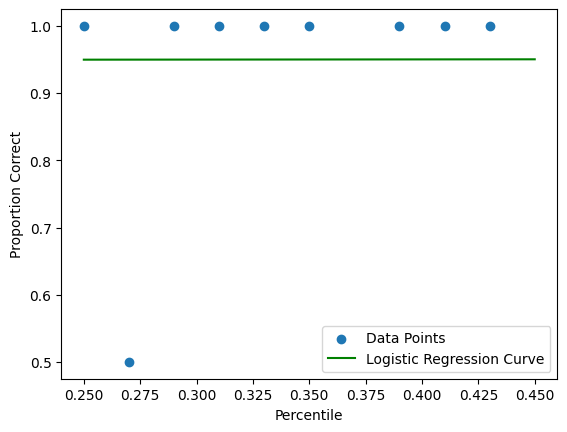

Percentile threshold for 95.0% accuracy: 0.3331832194134848


In [ ]:
# compare ratings
for ratings in ratings_both:
    # print average rejection rate
    avg_correct = ratings['rating'].mean()
    print(f"Average correct topic rate: {avg_correct:.2f}")
    # calculate mean ratings for every whole percentage step
    stepsize = 0.02
    percentile_segments = np.arange(prob_range[0], prob_range[1] + 1, stepsize)
    segment_n = len(percentile_segments)
    proportion_correct = []
    for i in range(len(percentile_segments)):
        if i == segment_n-1:
            upper_bound = percentile_segments[-1]
        else:
            lower_bound = percentile_segments[i]
            upper_bound = percentile_segments[i+1]
            segment_ratings = ratings[(ratings[f'topic_{topic_id}'] >= lower_bound) & (ratings[f'topic_{topic_id}'] < upper_bound)]
            if len(segment_ratings) > 0:
                prop_correct = segment_ratings['rating'].mean()
            else:
                prop_correct = np.nan
        proportion_correct.append(prop_correct)

    # fit logistic regression model
    # rating as categorical variable
    ratings['rating'] = ratings['rating'].astype(int)
    X = np.array(ratings[f'topic_{topic_id}']).reshape(-1, 1)
    y = np.array(ratings["rating"]).reshape(-1, 1)
    log_model = LogisticRegression()
    log_model.fit(X, y.ravel())

    # plot logistic regression curve
    plt.figure()
    plt.scatter(percentile_segments, proportion_correct, label='Data Points')
    # Generate a range of percentiles for smooth curve
    x_range = np.linspace(prob_range[0], prob_range[1], 300).reshape(-1, 1)
    # Predict probabilities using the logistic model
    y_prob = log_model.predict_proba(x_range)[:, 1]
    plt.plot(x_range, y_prob, color='green', label='Logistic Regression Curve')
    plt.xlabel('Topic Probability')
    plt.ylabel('Proportion Correct')
    plt.legend()
    plt.show()

    desired_accuracy = 0.95
    # Calculate the percentile threshold for the desired accuracy
    logit_threshold = np.log(desired_accuracy / (1 - desired_accuracy))
    coef = log_model.coef_[0][0]
    intercept = log_model.intercept_[0]
    percentile_threshold = (logit_threshold - intercept) / coef
    print(f"Topic probability threshold for {desired_accuracy*100}% accuracy: {percentile_threshold}")


In [ ]:
# combine ratings
ratings_combined = pd.concat(ratings_both, ignore_index=True)
desired_accuracy = 0.95

NameError: name 'pd' is not defined